In [1]:
import numpy as np
import pandas as pd
import os
from Bio import SeqIO
import itertools
from typing import List, Tuple
import string
from pathlib import Path
from tqdm.auto import tqdm, trange

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [22]:
pdcs_file = "/projects/bpms/jlaw/projects/pyruvate_decarboxylase_engineering/20230308_temperature_data_carboxy_lyases.csv"
df_pdcs = pd.read_csv(pdcs_file, header=[1])
df_pdcs = df_pdcs[df_pdcs.columns[:19]]
df_pdcs['Tm'] = df_pdcs['Tm'].apply(lambda x: str(x).replace('>','').replace('<','') if not pd.isnull(x) else x)
df_pdcs.head(2)

,prot_id,gene_name,protein_name,alternate_ids,pdb_id,mutations,sequence,species,taxon_id,new curation,brenda_literature,doi,ec_number,notes,pH_opt,pH_range,To,Tm,temperature stability
0,Q9WZ18; Q9WZ19,AHAS,NaN,"TM0548,TM0549",NaN,NaN,NaN,Thermotoga maritima,243274.0,y,746951,10.1016/j.bbrep.2016.07.008; 10.1016/j.bbrep.2...,2.2.1.6,"Q9WZ18 is the catalytic subunit, Q9WZ19 is the...",7,NaN,85.0,95,NaN
1,Q9WZ18; Q9WZ19,AHAS,NaN,"TM0548,TM0549",NaN,NaN,NaN,Thermotoga maritima,243274.0,y,746951,10.1016/j.bbrep.2016.07.008; 10.1016/j.bbrep.2...,2.2.1.6,"Q9WZ18 is the catalytic subunit, Q9WZ19 is the...",7,NaN,85.0,95,NaN


In [23]:
df_pdcs = df_pdcs.groupby('prot_id').min().reset_index()
df_pdcs['prot_id'] = df_pdcs['prot_id'].str.split('; ')
# df_pdcs['alternate_ids'] = df_pdcs['alternate_ids'].str.split('; ')
df_pdcs = df_pdcs.apply(pd.Series.explode)
df_pdcs

/tmp/ipykernel_31438/481373437.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the function.
  df_pdcs = df_pdcs.groupby('prot_id').min().reset_index()


,prot_id,gene_name,protein_name,alternate_ids,sequence,species,taxon_id,new curation,doi,To,Tm,temperature stability
0,A0A067Z5Y9,GoPDC,NaN,NaN,NaN,Gluconobacter oxydans,1288313.0,NaN,10.1107/S2053230X16012012,53.0,NaN,NaN
1,A0A1U9KDA0,NaN,phosphoenolpyruvate carboxylase,PEPC,NaN,Acetobacter aceti,435.0,y,NaN,55.0,60,NaN
2,A0A540NH00,NaN,phosphoenolpyruvate carboxylase,PEPC,NaN,Malus baccata,NaN,y,NaN,67.0,60,NaN
3,A0A6J1JZN1,GAD,Glutamate decarboxylase,NaN,NaN,Cucurbita maxima,NaN,y,NaN,60.0,NaN,NaN
4,A0M7G8,speA,Arginine decarboxylase,WP_011711464.1,NaN,Gramella forsetii,411154.0,y,NaN,30.0,62,NaN
5,A9H275,GdPDC,NaN,NaN,NaN,Gluconacetobacter diazotrophicus,272568.0,NaN,10.1107/S2053230X16012012,50.0,NaN,NaN
6,A9WJ56,ADC,NaN,YP_001634722,NaN,Chloroflexus aurantiacus,324602.0,y,NaN,70.0,75,NaN
7,E3GXT0,ppcA,phosphoenolpyruvate carboxylase,PEPC,NaN,Methanothermus sociabilis,NaN,y,NaN,85.0,85,"75C, no los of activity. 50% after 1 hr at 85"
8,O27026,ppcA,phosphoenolpyruvate carboxylase,PEPC,NaN,Methanothermobacter thermautotrophicus,187420.0,y,NaN,62.0,NaN,NaN
9,O28635,rbcL,Ribulose bisphosphate carboxylase,NaN,NaN,Archaeoglobus fulgidus,224325.0,y,NaN,83.0,NaN,NaN


<AxesSubplot: >

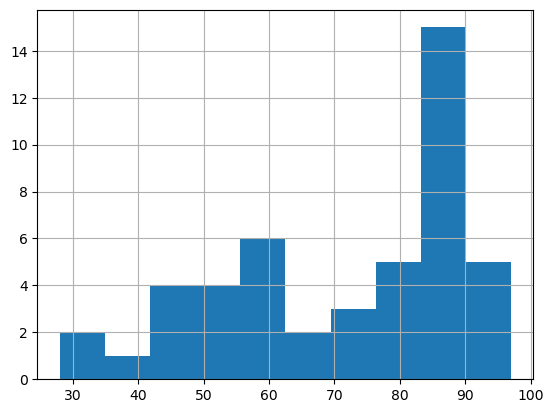

In [24]:
df_pdcs.To.hist()

<AxesSubplot: >

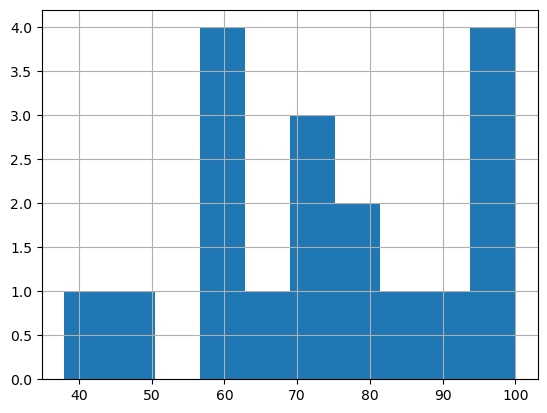

In [26]:
df_pdcs.Tm.astype(float).hist()

In [30]:
df_seqs = pd.read_table("/projects/bpms/jlaw/projects/pyruvate_decarboxylase_engineering/20230308_carboxy_lyases_sequences.tsv")
df_seqs.head(2)

,From,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length,Sequence
0,A0A067Z5Y9,A0A067Z5Y9,unreviewed,A0A067Z5Y9_GLUOY,Pyruvate decarboxylase Pdc (EC 4.1.1.1),pdc GLS_c11500,Gluconobacter oxydans DSM 3504,563,MTYTVGHYLAERLTQIGLKHHFAVAGDYNLVLLDQLIEQGGTKQIY...
1,A0A1U9KDA0,A0A1U9KDA0,unreviewed,A0A1U9KDA0_ACEAC,Phosphoenolpyruvate carboxylase,A0U92_02070,Acetobacter aceti,970,MAAASSSSGSPLIAGGDALSAGARAILAMGHFHESEGETQNPPPAE...


In [31]:
df_pdcs.set_index('prot_id', inplace=True)
df_pdcs.dropna(subset='sequence')

,gene_name,protein_name,alternate_ids,sequence,species,taxon_id,new curation,doi,To,Tm,temperature stability
prot_id,,,,,,,,,,,
Q8KTX6,ZpPDC,NaN,NaN,MYTVGMYLAERLAQIGLKHHFAVAGDYNLVLLDQLLLNKDMEQVYC...,Zymobacter palmae,33074.0,n,10.1107/S2053230X16012012; 10.1016/j.molcatb.2...,60.0,NaN,NaN


In [38]:
df_seqs.loc[df_seqs.From == 'Q8KTX6', 'Sequence'] = df_pdcs.dropna(subset='sequence').sequence.values[0]

In [40]:
df_pdcs['sequence'] = df_seqs.set_index('From').Sequence

In [42]:
df_pdcs.head(2)

,gene_name,protein_name,alternate_ids,sequence,species,taxon_id,new curation,doi,To,Tm,temperature stability
prot_id,,,,,,,,,,,
A0A067Z5Y9,GoPDC,NaN,NaN,MTYTVGHYLAERLTQIGLKHHFAVAGDYNLVLLDQLIEQGGTKQIY...,Gluconobacter oxydans,1288313.0,NaN,10.1107/S2053230X16012012,53.0,NaN,NaN
A0A1U9KDA0,NaN,phosphoenolpyruvate carboxylase,PEPC,MAAASSSSGSPLIAGGDALSAGARAILAMGHFHESEGETQNPPPAE...,Acetobacter aceti,435.0,y,NaN,55.0,60,NaN


In [29]:
# get the sequences for these uniprot IDs from uniprot
print(', '.join(df_pdcs.prot_id.values))

A0A067Z5Y9, A0A1U9KDA0, A0A540NH00, A0A6J1JZN1, A0M7G8, A9H275, A9WJ56, E3GXT0, O27026, O28635, O34714, O58679, O93627, P06169, P16467, P26263, P06672, P21885, P51060, Q31IK3, Q4JCJ1, Q51805, Q51803, Q51804, Q51799, Q56317, O05650, Q56316, O05651, Q57764, Q5JJ82, Q684J7, Q70YQ6, Q75VK8, Q8KTX6, Q8L388, Q8W2L5, Q9UVD7, Q9WZ18, Q9WZ19, V9NGI4, V9NFX1, V9NGQ2, V9NHA1, W8CQR1, W8CQB2, W8CQB1, W8CR61


### 2023-03-07

In [2]:
seqs_file = "/projects/bpms/jlaw/projects/pyruvate_decarboxylase_engineering/pdc_seqs.txt"
df_pdc = pd.read_csv(seqs_file, header=None, names=['seq_id', 'mutation', 'sequence'])
df_pdc['sequence'] = df_pdc.sequence.str.replace('HHHHHH-','')
df_pdc

,seq_id,mutation,sequence
0,WT,NaN,MTYTVGMYLAERLVQIGLKHHFAVAGDYNLVLLDQLLLNKDMKQIY...
1,>pCB131,M296,MTYTVGMYLAERLVQIGLKHHFAVAGDYNLVLLDQLLLNKDMKQIY...
2,>pCB139,M297,MYTVGMYLAERLAQIGLKHHFAVAGDYNLVLLDQLLLNKDMEQVYC...
3,>pCB140,M298,MTYTVGHYLAERLTQIGLKHHFAVAGDYNLVLLDQLIEQGGTKQIY...
4,>pCB141,M299,MTYTVGMYLAERLSQIGLKHHFAVAGDFNLVLLDQLLVNKEMEQVY...


In [6]:
df_pdc.loc[0].sequence

'MTYTVGMYLAERLVQIGLKHHFAVAGDYNLVLLDQLLLNKDMKQIYCCNELNCGFSAEGYARSNGAAAAVVTFSVGAISAMNAIGGAYAENLPVILISGSPNTNDYGTGHILHHTIGTTDYNYQLEMVKHVTCAAESIVSAEEAPAKIDHVIRTALRERKPAYLDIACNIASEPCVRPGPVSSLLSEPEIDHTSLKAAVDATVALLEKSASPVMLLGSKLRAANALAATETLADKLQCAVTIMAAAKGFFPEDHAGFRGLYWGEVSNPGVQELVETSDALLCIAPVFNDYSTVGWSAWPKGPNVILAEPDRVTVDGRAYDGFTLRAFLQALAEKAPARPASAQKSSVPTCSLTATSDEAGLTNDEIVRHINALLTSNTTLVAETGDSWFNAMRMTLPRGARVELEMQWGHIGWSVPSAFGNAMGSQDRQHVVMVGDGSFQVTAQEVAQMVRYELPVIIFLINNRGYVIEIAIHDGPYNYIKNWDYAGLMEVFNAGEGHGLGLKATTPKELTEAIARAKANTRGPTLIECQIDRTDCTDMLVQWGRKVASTNARKTTLA'

In [8]:
# try using the same train/test splits that flip used
inputs_dir = Path("/projects/robustmicrob/jlaw/inputs/")
df_split = pd.read_csv(Path(inputs_dir, "meltome/flip/github/splits/mixed_split.csv"))
print(len(df_split))
df_split.head(2)

27951


,sequence,target,set,validation
0,MSGEEEKAADFYVRYYVGHKGKFGHEFLEFEFRPNGSLRYANNSNY...,37.962947,train,NaN
1,MSMGSDFYLRYYVGHKGKFGHEFLEFEFRPDGKLRYANNSNYKNDV...,54.425342,train,NaN


In [9]:
# copied from here: https://stackoverflow.com/a/29805905/7483950
def read_fasta(fp, gzipped=False):
        name, seq = None, []
        for line in fp:
            if gzipped:
                line = line.decode()
            line = line.rstrip()
            if line.startswith(">"):
                if name: yield (name, ''.join(seq))
                name, seq = line[1:], []
            else:
                seq.append(line)
        if name: yield (name, ''.join(seq))

In [15]:
data_file = Path(inputs_dir, "meltome/flip/sequences.fasta")
print(f"reading {data_file}")
data = {}
with open(data_file, 'r') as f:
    for name, seq in read_fasta(f):
        # make sure there aren't these strange AAs
        seq = seq.replace('B', 'D').replace('Z', 'E').replace('J', 'L')
        data[name] = seq

print(f"\t{len(data)} read")

reading /projects/robustmicrob/jlaw/inputs/meltome/flip/sequences.fasta
	34005 read


In [16]:
list(data.items())[:2]

[('tr|A0A023T4K3|A0A023T4K3_CAEEL Mago nashi protein OS=Caenorhabditis elegans OX=6239 PE=2 SV=1',
  'MSGEEEKAADFYVRYYVGHKGKFGHEFLEFEFRPNGSLRYANNSNYKNDTMIRKEATVSESVLSELKRIIEDSEIMQEDDDNWPEPDKIGRQELEILYKNEHISFTTGKIGALADVNNSKDPDGLRSFYYLVQDLKCLVFSLIGLHFKIKPI'),
 ('tr|A0A023T778|A0A023T778_MOUSE Mago nashi protein OS=Mus musculus OX=10090 GN=Magohb PE=1 SV=1',
  'MSMGSDFYLRYYVGHKGKFGHEFLEFEFRPDGKLRYANNSNYKNDVMIRKEAYVHKSVMEELKRIIDDSEITKEDDALWPPPDRVGRQELEIVIGDEHISFTTSKIGSLIDVNQSKDPEGLRVFYYLVQDLKCLVFSLIGLHFKIKPI')]

In [17]:
seqs = {key.split(' ')[0]: seq for key, seq in data.items()}

In [22]:
blast_hits = ["sp|Q9FFT4|PDC2_ARATH", "sp|P16467|PDC5_YEAST", "sp|P26263|PDC6_YEAST", "sp|P06169|PDC1_YEAST",
              "sp|Q9LF46|HACL_ARATH", "sp|P08142|ILVB_ECOLI", "sp|P37251|ILVB_BACSU", "sp|P00893|ILVI_ECOLI",
             ]

In [24]:
blast_hit_seqs

{'sp|Q9FFT4|PDC2_ARATH': 'MDTKIGSIDACNPTNHDIGGPPNGGVSTVQNTSPLHSTTVSPCDATLGRYLARRLVEIGVTDVFSVPGDFNLTLLDHLIAEPNLKLIGCCNELNAGYAADGYARSRGVGACVVTFTVGGLSVLNAIAGAYSENLPLICIVGGPNSNDYGTNRILHHTIGLPDFTQELRCFQAVTCFQAVINNLEEAHELIDTAISTALKESKPVYISISCNLPAIPLPTFSRHPVPFMLPMKVSNQIGLDAAVEAAAEFLNKAVKPVLVGGPKMRVAKAADAFVELADASGYGLAVMPSAKGQVPEHHKHFIGTYWGAVSTAFCAEIVESADAYLFAGPIFNDYSSVGYSLLLKKEKAIIVQPDRVTIGNGPAFGCVLMKDFLSELAKRIKHNNTSYENYHRIYVPEGKPLRDNPNESLRVNVLFQHIQNMLSSESAVLAETGDSWFNCQKLKLPEGCGYEFQMQYGSIGWSVGATLGYAQAMPNRRVIACIGDGSFQVTAQDVSTMIRCGQKTIIFLINNGGYTIEVEIHDGPYNVIKNWNYTAFVEAIHNGEGKCWTAKVRCEEELVKAINTATNEEKESFCFIEVIVHKDDTSKELLEWGSRVSAANSRPPNPQ',
 'sp|P16467|PDC5_YEAST': 'MSEITLGKYLFERLSQVNCNTVFGLPGDFNLSLLDKLYEVKGMRWAGNANELNAAYAADGYARIKGMSCIITTFGVGELSALNGIAGSYAEHVGVLHVVGVPSISSQAKQLLLHHTLGNGDFTVFHRMSANISETTAMITDIANAPAEIDRCIRTTYTTQRPVYLGLPANLVDLNVPAKLLETPIDLSLKPNDAEAEAEVVRTVVELIKDAKNPVILADACASRHDVKAETKKLMDLTQFPVYVTPMGKGAIDEQHPRYGGVYVGTLSRPEVKKAVESADLILSIGALLSDFNTGSFSYSYKTKNIVEFHSDHIKIRNATFPGVQMKFALQKLLDAIP

In [23]:
blast_hit_seqs = {hit: seqs[hit] for hit in blast_hits}
df_split[df_split.sequence.isin(blast_hit_seqs.values())]
    

,sequence,target,set,validation
6677,MSEITLGKYLFERLKQVNVNTIFGLPGDFNLSLLDKIYEVDGLRWA...,48.646713,test,NaN


In [26]:
df_split.head(2)

,sequence,target,set,validation
0,MSGEEEKAADFYVRYYVGHKGKFGHEFLEFEFRPNGSLRYANNSNY...,37.962947,train,NaN
1,MSMGSDFYLRYYVGHKGKFGHEFLEFEFRPDGKLRYANNSNYKNDV...,54.425342,train,NaN


In [25]:
blast_hit_seqs.values()

dict_values(['MDTKIGSIDACNPTNHDIGGPPNGGVSTVQNTSPLHSTTVSPCDATLGRYLARRLVEIGVTDVFSVPGDFNLTLLDHLIAEPNLKLIGCCNELNAGYAADGYARSRGVGACVVTFTVGGLSVLNAIAGAYSENLPLICIVGGPNSNDYGTNRILHHTIGLPDFTQELRCFQAVTCFQAVINNLEEAHELIDTAISTALKESKPVYISISCNLPAIPLPTFSRHPVPFMLPMKVSNQIGLDAAVEAAAEFLNKAVKPVLVGGPKMRVAKAADAFVELADASGYGLAVMPSAKGQVPEHHKHFIGTYWGAVSTAFCAEIVESADAYLFAGPIFNDYSSVGYSLLLKKEKAIIVQPDRVTIGNGPAFGCVLMKDFLSELAKRIKHNNTSYENYHRIYVPEGKPLRDNPNESLRVNVLFQHIQNMLSSESAVLAETGDSWFNCQKLKLPEGCGYEFQMQYGSIGWSVGATLGYAQAMPNRRVIACIGDGSFQVTAQDVSTMIRCGQKTIIFLINNGGYTIEVEIHDGPYNVIKNWNYTAFVEAIHNGEGKCWTAKVRCEEELVKAINTATNEEKESFCFIEVIVHKDDTSKELLEWGSRVSAANSRPPNPQ', 'MSEITLGKYLFERLSQVNCNTVFGLPGDFNLSLLDKLYEVKGMRWAGNANELNAAYAADGYARIKGMSCIITTFGVGELSALNGIAGSYAEHVGVLHVVGVPSISSQAKQLLLHHTLGNGDFTVFHRMSANISETTAMITDIANAPAEIDRCIRTTYTTQRPVYLGLPANLVDLNVPAKLLETPIDLSLKPNDAEAEAEVVRTVVELIKDAKNPVILADACASRHDVKAETKKLMDLTQFPVYVTPMGKGAIDEQHPRYGGVYVGTLSRPEVKKAVESADLILSIGALLSDFNTGSFSYSYKTKNIVEFHSDHIKIRNATFPGVQMKFALQKLLDAIPEVVKDYKPVAVPARVPITKSTPANTPMKQEWMWNHLG

In [27]:
df_cs = pd.read_csv(Path(inputs_dir, "meltome/flip/cross-species.csv"))
df_cs.head(2)

/tmp/ipykernel_24979/1161380544.py:1: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cs = pd.read_csv(Path(inputs_dir, "meltome/flip/cross-species.csv"))


,run_name,Protein_ID,gene_name,meltPoint,channel,fold_change,temperature
0,Bacillus subtilis_168_lysate_R1,C0H3Q1_ytzI,ytzI,NaN,TMT126,0.999203,30.0
1,Bacillus subtilis_168_lysate_R1,C0H3V2_mtlF,mtlF,56.693844,TMT126,0.999203,30.0


In [32]:
'ab'.lower()

'ab'

In [33]:
blast_hit_seqs2 = {key.split('|')[1] + "_" + key.split('|')[2].split('_')[0]: seq 
                   for key, seq in blast_hit_seqs.items()}
blast_hit_seqs3 = {key.split('|')[1] + "_" + key.split('|')[2].split('_')[0].lower(): seq 
                   for key, seq in blast_hit_seqs.items()}
hit_ids = set(blast_hit_seqs2.keys()) | set(blast_hit_seqs3.keys())

In [31]:
blast_hit_seqs2.keys()

dict_keys(['Q9FFT4_PDC2', 'P16467_PDC5', 'P26263_PDC6', 'P06169_PDC1', 'Q9LF46_HACL', 'P08142_ILVB', 'P37251_ILVB', 'P00893_ILVI'])

In [35]:
hit_ids

{'P00893_ILVI',
 'P00893_ilvi',
 'P06169_PDC1',
 'P06169_pdc1',
 'P08142_ILVB',
 'P08142_ilvb',
 'P16467_PDC5',
 'P16467_pdc5',
 'P26263_PDC6',
 'P26263_pdc6',
 'P37251_ILVB',
 'P37251_ilvb',
 'Q9FFT4_PDC2',
 'Q9FFT4_pdc2',
 'Q9LF46_HACL',
 'Q9LF46_hacl'}

In [38]:
df_cs['prot_id'] = df_cs.Protein_ID.astype(str).apply(lambda x: x.upper())

In [40]:
df_cs[df_cs.prot_id.isin(hit_ids)].groupby(['run_name', 'Protein_ID'])['meltPoint'].mean()

run_name                              Protein_ID 
Arabidopsis thaliana seedling lysate  Q9FFT4_PDC2    46.353152
                                      Q9LF46_HACL    47.622808
Bacillus subtilis_168_lysate_R1       P37251_ilvB    44.489131
Escherichia coli cells                P00893_ilvI    55.168487
                                      P08142_ilvB    51.667821
Escherichia coli lysate               P08142_ilvB    58.181653
Saccharomyces cerevisiae lysate       P06169_PDC1    47.709385
                                      P16467_PDC5    48.731847
                                      P26263_PDC6    48.646713
Name: meltPoint, dtype: float64

In [ ]:
df_cs